In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import moca, espra, smooth, tilt_distance_LI, robust_smooth, axis_ratio
from utils import normalize_matrix, calc_ow, fit_psi_params, psi_params
from utils import project_sadcp_to_transect, translate_moca_results


### Satellite Data

In [2]:
ssh_path = '/srv/scratch/z5297792/ESP_Paper_Data/sat_data_IMOS_drifters.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


### SADCP Data

In [3]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/ESP_Paper_Data/sadcp_data_CCE_2023.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=['u_' + str(z) for z in z_sadcp]).T
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=['v_' + str(z) for z in z_sadcp]).T
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Time': tim_sadcp, 'Lon': lon_sadcp, 'Lat': lat_sadcp})
df_sadcp = pd.concat([df_sadcp, u_sadcp, v_sadcp], axis=1)

df_sadcp = df_sadcp[df_sadcp['Lat'] <= -37]
df_sadcp = df_sadcp.reset_index().drop(columns=['index'])

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
df_sadcp['x'] = (df_sadcp.Lon - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
df_sadcp['y'] = (df_sadcp.Lat - phi_mean) * 111000

df_sadcp


,Time,Lon,Lat,u_27,u_37,u_47,u_57,u_67,u_77,u_87,...,v_737,v_747,v_757,v_767,v_777,v_787,v_797,v_807,x,y
0,2023-10-17 10:27:31.000004,154.357059,-37.005208,NaN,0.534412,0.569007,0.549270,0.465635,0.374654,0.323217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4997.725425,99321.875000
1,2023-10-17 10:42:30.333327,154.360804,-37.038123,NaN,0.533096,0.555601,0.561888,0.484809,0.402146,0.357385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5325.695073,95668.330556
2,2023-10-17 10:57:30.666685,154.364625,-37.071899,NaN,0.431565,0.456292,0.483472,0.458337,0.434674,0.398060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5660.396047,91919.202778
3,2023-10-17 11:12:30.333340,154.368274,-37.101418,NaN,0.368063,0.378524,0.410269,0.398222,0.362505,0.358032,...,0.043708,0.042462,NaN,NaN,NaN,NaN,NaN,NaN,5980.012364,88642.647222
4,2023-10-17 11:27:30.666659,154.372221,-37.104340,NaN,0.357789,0.368125,0.399916,0.385093,0.353109,0.356878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6325.742980,88318.280556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,2023-10-21 21:27:30.333314,154.179344,-37.150309,NaN,0.246921,0.241454,0.244281,0.212926,0.202732,0.233854,...,0.080013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10568.100129,83215.672222
429,2023-10-21 21:42:30.666672,154.179347,-37.119931,NaN,0.222701,0.196322,0.206364,0.223129,0.236286,0.265476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10567.775728,86587.708333
430,2023-10-21 21:57:30.333327,154.179332,-37.088953,NaN,0.214721,0.206698,0.228885,0.243320,0.250907,0.249915,...,0.085535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10569.073333,90026.241667
431,2023-10-21 22:12:30.333314,154.179352,-37.058304,NaN,0.219740,0.226015,0.243559,0.245731,0.227310,0.231003,...,0.077085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10567.370226,93428.288889


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


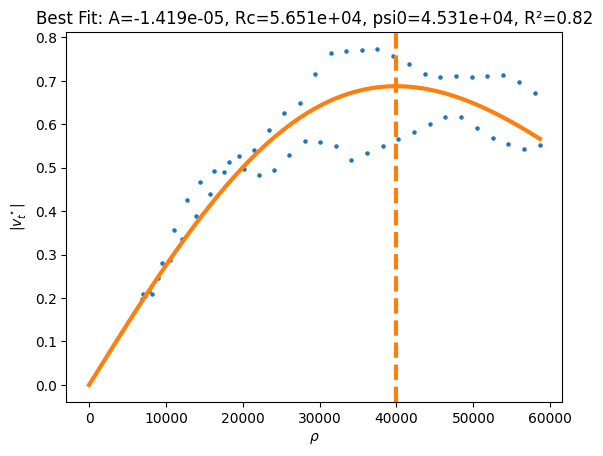

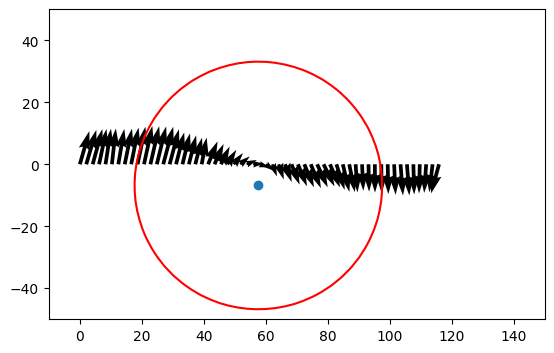

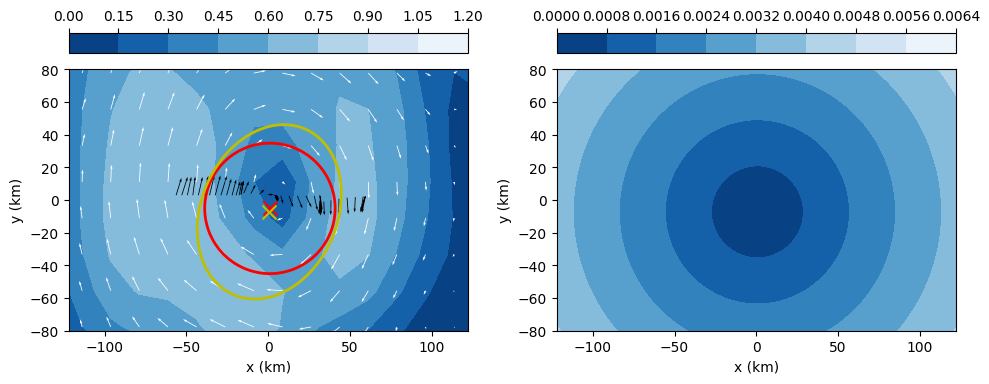

In [68]:
z = 37
t0 = pd.Timestamp('2023-10-20 12:00:00')
dt = pd.Timedelta(days=0.3)

m = (df_sadcp.Time.between(t0 - dt, t0 + dt))
dft = df_sadcp.loc[m]

xi, yi = dft.x.values, dft.y.values
ui, vi = dft[f'u_{z}'].values, dft[f'v_{z}'].values


# --- MOCA projection + fit ---
df_proj, moca_meta = project_sadcp_to_transect(xi, yi, ui, vi)

l0, r0, w, Q, Rc, psi0, A = moca(
    df_proj.l, df_proj.V_T, df_proj.V_N, plot_flag=True
)

xc, yc = translate_moca_results(
    df_proj.iloc[0].x, df_proj.iloc[0].y, moca_meta, l0, r0
)


# --- Transect view ---
L = np.linspace(-150e3, 150e3, 101)
X, Y = np.meshgrid(L, L, indexing='ij')

dx = X/1e3 - l0/1e3
dy = Y/1e3 - r0/1e3

rho2 = Q[0,0]*dx**2 + 2*Q[1,0]*dx*dy + Q[1,1]*dy**2

fig, ax = plt.subplots()
ax.quiver(df_proj.l/1e3, np.zeros(len(df_proj)), df_proj.V_T, df_proj.V_N)
ax.scatter(l0/1e3, r0/1e3)
ax.contour(X/1e3, Y/1e3, rho2, levels=[(Rc/1e3)**2/2], colors='r')
ax.set(xlim=(-10,150), ylim=(-50,50), aspect='equal')


# --- SSH snapshot closest in time ---
t_closest = min(tim_ssh, key=lambda t: abs(t - t0))
ut, vt = dic_ssh_data[t_closest]['u'], dic_ssh_data[t_closest]['v']

fig, axs = plt.subplots(1,2, figsize=(10,4))

speed = np.hypot(ut, vt)
cb = axs[0].contourf(x_ssh/1e3, y_ssh/1e3, speed, cmap='Blues_r')
fig.colorbar(cb, ax=axs[0], location='top')

sp = 1
scale = 15
gap = 70

axs[0].quiver(
    x_ssh[::sp,::sp]/1e3, y_ssh[::sp,::sp]/1e3,
    ut[::sp,::sp], vt[::sp,::sp],
    width=.002, scale=scale, color='w'
)

# axs[0].plot(df_sadcp.x/1e3, df_sadcp.y/1e3, 'k', lw=.5, alpha=.5)
axs[0].quiver(xi/1e3, yi/1e3, ui, vi, scale=scale, width=.002)

axs[0].scatter(xc/1e3, yc/1e3, c='r', s=100, marker='x', zorder=5)

dx = X/1e3 - xc/1e3
dy = Y/1e3 - yc/1e3
rho2 = Q[0,0]*dx**2 + 2*Q[1,0]*dx*dy + Q[1,1]*dy**2
axs[0].contour(X/1e3, Y/1e3, rho2, levels=[(Rc/1e3)**2/2], colors='r', linewidths=2)

axs[0].axis('equal')
axs[0].set_xlim(L.min()/1e3 + gap, L.max()/1e3 - gap)
axs[0].set_ylim(L.min()/1e3 + gap, L.max()/1e3 - gap)
axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')

# --- ESPRA ---
xc_e, yc_e, w_e, Q_e, Rc_e, psi0_e, A_e = espra(xi, yi, ui, vi)
# xc_e, yc_e, w_e, Q_e, Rc_e, psi0_e, A_e = espra(df_proj.l/1e3, np.zeros(len(df_proj)), df_proj.V_T, df_proj.V_N)
axs[0].scatter(xc_e/1e3, yc_e/1e3, c='y', s=100, marker='x', zorder=5)
dx = X/1e3 - xc_e/1e3
dy = Y/1e3 - yc_e/1e3
rho2 = Q_e[0,0]*dx**2 + 2*Q_e[1,0]*dx*dy + Q_e[1,1]*dy**2
axs[0].contour(X/1e3, Y/1e3, rho2, levels=[(Rc_e/1e3)**2/2], colors='y', linewidths=2)

# Reco
u = - A * np.exp( - rho2 / Rc**2 ) * ( 2*Q[1,0]*dx + 2*Q[1,1]*dy)
v =   A * np.exp( - rho2 / Rc**2 ) * ( 2*Q[0,0]*dx + 2*Q[1,0]*dy)
spd = np.hypot(u, v)
cb = axs[1].contourf(X/1e3, Y/1e3, spd, cmap='Blues_r')
fig.colorbar(cb, ax=axs[1], location='top')
axs[1].axis('equal')
axs[1].set_xlim(L.min()/1e3 + gap, L.max()/1e3 - gap)
axs[1].set_ylim(L.min()/1e3 + gap, L.max()/1e3 - gap)
axs[1].set_xlabel('x (km)'); axs[1].set_ylabel('y (km)')

plt.tight_layout()


